# ACCEL IMPLEMENTATION

In [2]:
print("Start")

Start


In [2]:
import os
import torch
import wandb
import imageio
import numpy as np
import gymnasium as gym

import matplotlib.pyplot as plt

from PIL import Image

from collections import deque

from gymnasium.spaces import Box

from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Goal, Wall
from minigrid.minigrid_env import MiniGridEnv, Grid

from minigrid.wrappers import ImgObsWrapper

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv

os.environ["WANDB_SILENT"] = "true"


device = 'cpu'
print(f"Using device: {device}")

# ====================================================
# 1. Custom MiniGrid Environment that returns only the image
#    for SB3's PPO (which expects a Box space).
# ====================================================
class MyCustomGrid(MiniGridEnv):
    """
    Simple MiniGrid environment that places random wall tiles
    according to a config dict, returning only the 'image' observation.
    """

    def __init__(self, config=None, solvable_only=False, **kwargs):
        if config is None:
            config = {}
        self.config = config
        self.solvable_only = solvable_only

        # Create a random number generator with the custom seed
        self.rng = np.random.default_rng(seed=self.config.get("seed_val"))

        mission_space = MissionSpace(mission_func=lambda: "get to the green goal square")

        super().__init__(
            grid_size=self.config['width'],
            max_steps=self.config['width'] * self.config['height'] * 2, # max_steps is typically 2x the grid size
            see_through_walls=False,
            agent_view_size=5,                      # Size of the agent's view square
            mission_space=mission_space,
            **kwargs
        )

        # Manually define our observation_space as a single Box (the image).
        # By default, MiniGrid's image shape is (view_size, view_size, 3) if using partial obs,
        # or (height, width, 3) if using full-grid observation. We'll do full-grid here:
        # We'll define (self.height, self.width, 3) as the shape.
        # In practice, "image" shape can vary if partial observations are used.
        self.observation_space = Box(
            low=0,
            high=255,
            shape=(self.agent_view_size, self.agent_view_size, 3),
            dtype=np.uint8
        )

            
    def _gen_grid(self, width, height):
        """
        Generate a new environment layout ensuring solvability if required.
        """
        
        check_stuck = 0
        while True:  # Keep regenerating until a solvable layout is found
            self.grid = Grid(width, height)
            self.grid.wall_rect(0, 0, width, height)

            # Place the goal
            goal_pos = self.config.get("goal_pos")
            if goal_pos is None:
                while True:
                    goal_r = self.rng.integers(1, height - 1)
                    goal_c = self.rng.integers(1, width - 1)
                    if self.grid.get(goal_c, goal_r) is None:
                        self.put_obj(Goal(), goal_c, goal_r)
                        self.config["goal_pos"] = (goal_c, goal_r)
                        break
            else:
                self.put_obj(Goal(), goal_pos[0], goal_pos[1])

            # Place the agent
            start_pos = self.config.get("start_pos")
            if start_pos is None:
                while True:
                    start_r = self.rng.integers(1, height - 1)
                    start_c = self.rng.integers(1, width - 1)
                    if self.grid.get(start_c, start_r) is None and (start_c, start_r) != self.config["goal_pos"]:
                        self.agent_pos = (start_c, start_r)
                        self.agent_dir = self.rng.integers(0, 4)
                        self.config["start_pos"] = (start_c, start_r)
                        break
            else:
                self.agent_pos = start_pos
                self.agent_dir = self.rng.integers(0, 4)
                self.config["start_pos"] = start_pos
            
            placed_blocks = 0
            
            # Maximum number of tries to place the blocks
            max_num_tries = 100
            
            # Place random walls using config parameters
            while placed_blocks < self.config["num_blocks"]:
                max_num_tries -= 1
                r = self.rng.integers(1, height - 1)
                c = self.rng.integers(1, width - 1)
                if max_num_tries <= 0:
                    print("Could not place all blocks in the grid.")
                    break
                if self.grid.get(c, r) is None and (c, r) != self.config["start_pos"] and (c, r) != self.config["goal_pos"]:
                    self.put_obj(Wall(), c, r)
                    placed_blocks += 1

            # Check solvability if required
            if not self.solvable_only or self._is_solvable():
                break
            
            check_stuck += 1
            if check_stuck > 50:
                print("Re-randomizing start and goal positions...")
                self.config.pop("start_pos", None)
                self.config.pop("goal_pos", None)
                self.rng = np.random.default_rng(seed=self.config.get("seed_val") + check_stuck)

        
    def _is_solvable(self):
        """
        Uses Breadth-First Search (BFS) to check if there's a path 
        from the agent's start position to the goal.
        """
        start_pos = self.config["start_pos"]
        goal_pos = self.config["goal_pos"]
        if not start_pos or not goal_pos:
            return False

        queue = deque([start_pos])
        visited = set()
        visited.add(start_pos)

        while queue:
            x, y = queue.popleft()
            if (x, y) == goal_pos:
                return True

            # Possible moves: up, down, left, right
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy
                cell_obj = self.grid.get(nx, ny)
                if (
                    1 <= nx < self.width - 1 and  # Stay within grid bounds
                    1 <= ny < self.height - 1 and
                    (nx, ny) not in visited and
                    self.grid.get(nx, ny) is None or isinstance(cell_obj, Goal)
                ):
                    queue.append((nx, ny))
                    visited.add((nx, ny))
        return False  # No path found

    def reset(self, **kwargs):
        """
        Override reset to ensure we only return the 'image' array
        instead of a dict with 'image' and 'mission'.
        """
        obs, info = super().reset(**kwargs)
        obs = self._convert_obs(obs)
        
        return obs, info

    def step(self, action):
        """
        Same for step: override to convert the dict observation into an image only.
        """
        obs, reward, done, truncated, info = super().step(action)
        obs = self._convert_obs(obs)
        return obs, reward, done, truncated, info

    def _convert_obs(self, original_obs):
        """
        original_obs is typically {'image':..., 'mission':...}.
        We'll just return original_obs['image'] to get a Box(low=0,high=255) shape.
        """
        return original_obs["image"]
        #return np.transpose(original_obs["image"], (2, 0, 1))
    
    def update_config(self, new_config):
        self.config = new_config
        self.reset()



def random_config(grid_size, num_blocks=None, seed=None):
    max_blocks = int(((grid_size - 1) * (grid_size - 1)) / 2)
    
    if num_blocks is None:
        num_blocks = np.random.randint(1, max_blocks)
    else:
        num_blocks = min(num_blocks, max_blocks)
        
    config = {
        "width": grid_size,
        "height": grid_size,
        "num_blocks": num_blocks,
        "start_pos": None,
        "goal_pos": None,
        "edited": False,
        "seed_val": seed if seed is not None else np.random.randint(0, 1000)
    }
    
    # Set the start and goal positions
    env = MyCustomGrid(config)
    
    # Reset the environment to get the start and goal positions
    env.reset()
    
    # Get the new config from the environment
    config = env.config
        
    return config

def print_level_from_config(config, solvable_only=False):
    #print("Putting up the level from config:", config)
    env = MyCustomGrid(config, render_mode='rgb_array', solvable_only=solvable_only)
    env.reset()
    full_level_image = env.render()  # This should return an RGB image of the full grid

    plt.figure(figsize=(4, 4))
    plt.imshow(full_level_image)
    plt.title("Level Configuration: " + str(config))
    plt.axis("off")
    plt.show()
    
# Modify an existing configuration, adding randomness.
def edit_config(old_config):
    max_blocks = int(((old_config["width"] - 1) * (old_config["height"] - 1)) / 2)
    
    new_config = dict(old_config)
    
    # Randomly change the number of blocks
    new_number_blocks = old_config["num_blocks"] + np.random.choice([-1, 1, 2, 3])
    
    # Ensure the number of blocks is within bounds
    new_config["num_blocks"] = max(1, min(new_number_blocks, max_blocks))    
    
    # Mark the config as edited
    new_config["edited"] = True
    
    return new_config
    
import numpy as np

"""def edit_config(old_config, difficulty_level=1):

    width, height = old_config["width"], old_config["height"]
    total_cells = width * height

    # Define a baseline max number of blocks
    max_blocks = int(0.6 * total_cells)  # Ensure we don't overcrowd (max 60% coverage)
    
    # Calculate the new number of blocks using a logarithmic scale
    base_growth = int(np.log2(total_cells) * difficulty_level)
    
    # Introduce some randomness while keeping it within a reasonable range
    growth_factor = np.random.randint(base_growth // 2, base_growth + 1)
    
    # Compute the new block count
    new_number_blocks = old_config["num_blocks"] + growth_factor
    
    # Ensure it's within the allowed range
    new_config = dict(old_config)
    new_config["num_blocks"] = max(1, min(new_number_blocks, max_blocks))  
    
    # Mark as edited
    new_config["edited"] = True

    return new_config
"""



# ====================================================
# 2. Simple “level buffer” 
# ====================================================
# class to memorize generated levels and score
class LevelBuffer: 
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []  # will store (config_dict, score)

    def add(self, config, score):
        self.data.append((config, score))
        if len(self.data) > self.max_size:
            self.data.sort(key=lambda x: x[1], reverse=True)
            self.data = self.data[: self.max_size]
            #it memorize only the highest score for each level

    def sample_config(self): 
        # Samples a level from the buffer, weighting the probabilities 
        # based on the scores.
        if len(self.data) == 0:
            return None
        scores = [item[1] for item in self.data]
        total = sum(scores)
        if total <= 1e-9:
            # fallback to uniform
            idx = np.random.randint(len(self.data))
            return self.data[idx][0]
        probs = [s / total for s in scores]
        idx = np.random.choice(len(self.data), p=probs)
        return self.data[idx][0]

# ====================================================
# 3. Utility Functions
# ====================================================

# Calculate regret using Generalized Advantage Estimation (GAE) with Stable-Baselines3's PPO model.
# PLR approximates regret using a score function such as the positive value loss.
def calculate_regret_gae(env, model, max_steps, gamma, lam):
    """
    Calculate regret using Generalized Advantage Estimation (GAE)
    with Stable-Baselines3's PPO model.
    """
    obs, _ = env.reset()
    regrets = []
    rewards = []
    dones = []
    values = []

    for t in range(max_steps):
        # Add batch dimension to the observation tensor
        obs_tensor = torch.as_tensor(obs).float().unsqueeze(0).to(device)
        
        # Use the model's policy to get the value and action.
        # For actions, model.predict handles single observations well.
        action, _ = model.predict(obs, deterministic=True)
        
        # Compute the value from the policy.
        value_t = model.policy.predict_values(obs_tensor).item()
        values.append(value_t)
        
        # Perform the step in the environment
        obs, reward, done, truncated, _ = env.step(action)
        rewards.append(reward)
        dones.append(done)

        if done or truncated:
            break

    # Add value of the terminal state (0 if done/truncated)
    if done or truncated:
        terminal_value = 0.0
    else:
        terminal_obs_tensor = torch.as_tensor(obs).float().unsqueeze(0).to(device)
        terminal_value = model.policy.predict_values(terminal_obs_tensor).item()
    values.append(terminal_value)

    # Compute TD-errors and GAE-like regret score
    for t in range(len(rewards)):
        delta_t = rewards[t] + gamma * values[t + 1] * (1 - dones[t]) - values[t]
        discounted_error = (gamma * lam) ** t * delta_t
        regrets.append(max(0, discounted_error))

    # Return the maximum positive regret score (or 0 if empty)
    return max(regrets) if regrets else 0.0


def initialize_ppo(env, learning_rate=1e-4):
    return PPO(
        "MlpPolicy",                    # Multi-layer perceptron policy
        env,                            # environment to learn from
        verbose=0,                      # Display training output
        n_steps=256,                    # Number of steps to run for each environment per update
        batch_size=64,                  # Minibatch size for each gradient update
        learning_rate=learning_rate,    # Learning rate for optimizer
        device=device                   # Use GPU if available
    )
    
# Use vectorized environment
def create_vectorized_env(config, n_envs=4, solvable_only=False):
    """
    Create a vectorized environment with n parallel environments.
    """
    return make_vec_env(lambda: MyCustomGrid(config, solvable_only), n_envs=n_envs, vec_env_cls=SubprocVecEnv)



def evalute_models(load_dim = -1, grid_size = 6, n_eval_episodes = 5, num_levels_per_difficulty = 10):
    
    if load_dim > 0:
        # Load the models
        model_dr = PPO.load(f"models/dr_model_{load_dim}x{load_dim}")
        model_plr = PPO.load(f"models/plr_model_{load_dim}x{load_dim}")
        model_accel = PPO.load(f"models/accel_model_{load_dim}x{load_dim}")
        model_accel_easy = PPO.load(f"models/accel_model_easy_{load_dim}x{load_dim}")

    # Inseert the models in a dictionary
    models = {"DR": model_dr, 'PLR': model_plr, 'ACCEL': model_accel, 'ACCEL-EasyStart': model_accel_easy}

    # Generate n levels difficulties with increasing complexity, for each level generate m configs
    difficulties = 3
    num_levels_per_difficulty = num_levels_per_difficulty

    levels = []
    for i in range(difficulties):
        level = []
        for _ in range(num_levels_per_difficulty):
            cfg = random_config(grid_size, num_blocks=grid_size*(i+1))
            #print_level_from_config(cfg, solvable_only=True)
            level.append(cfg)
        levels.append(level)
        
    
    # Create a dummy config to initialize the vectorized environment
    dummy_config = random_config(grid_size)
    env = create_vectorized_env(dummy_config, n_envs=4, solvable_only=True)

    # Evaluate the model on the generated levels
    results = {}
    for model_name, model in models.items():
        results[model_name] = []
        for i, level in enumerate(levels):
            print(f"Evaluating {num_levels_per_difficulty} levels of difficulty {i + 1} with {grid_size*(i+1)} blocks on a {grid_size}x{grid_size} grid for model {model_name}, ratio of blocks to grid size: {grid_size*(i+1) / (grid_size*grid_size):.2f}")
            r = []
            for j, cfg in enumerate(level):
                # Update the environment with the new config
                env.env_method("update_config", cfg)
                mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, deterministic=True)
                r.append(mean_reward)
            results[model_name].append(r)
        print()
        
    # Print mean rewards for each level
    for model_name in models.keys():
        print(f"Model: {model_name}")
        for i, level in enumerate(levels):
            print(f"Level {i + 1} - Complexity {grid_size*(i+1)}: {np.mean(results[model_name][i]):.2f}")
        print()
    
    #Comute the number of xticks based on the number of models
    xticks = [i for i in range(1, len(models.keys()) + 1)]

    # Boxplot of results, a plot for each level complexity comparing models
    plt.figure(figsize=(12, 6))
    for i, level in enumerate(levels):
        plt.subplot(1, difficulties, i + 1)
        plt.boxplot([results[model_name][i] for model_name in models.keys()])
        plt.xticks([1,2,3,4], [model_name for model_name in models.keys()])
        plt.title(f"Level {i + 1} - Complexity {grid_size*(i+1)}")
        plt.ylabel("Mean Reward")
    plt.tight_layout()
    plt.show()
    
    # Save the figure
    plt.savefig(f"plots/boxplot_{load_dim}x{load_dim}.png")
    
    
def main_accel(total_iterations, replay_prob, train_steps, level_buffer_size,
               initial_fill_size, grid_size, n_envs, edit_levels, regret_threshold,
               easy_start, domain_randomization, name):
    
    # Initialize Weights and Biases
    wandb.init(project="accel", config=config)
    
    # Create a level buffer, a personal class to store levels and scores
    level_buffer = LevelBuffer(max_size=level_buffer_size)
    
    # Generate a random configuration {width, height, num_blocks, start_pos, goal_pos}
    dummy_config = random_config(grid_size)
    
    # Create a vectorized environment, so a wrapper for MyCustomGrid that allows interconnection 
    # between gymnasium and stable-baselines3 to train the model in a vectorized way, since we
    # are using DummyVecEnv, it is not true parallelism
    vectorized_env = create_vectorized_env(dummy_config, n_envs=n_envs)

    # Initialize PPO with vectorized environment
    print("Initializing student model PPO...")
    student_model = initialize_ppo(vectorized_env)
            
        

    # ====================================================
    # Initial buffer fill
    # ====================================================
    if not domain_randomization:
        print(f"Populating buffer with {initial_fill_size} initial levels with regret > {regret_threshold}...")
        while len(level_buffer.data) < initial_fill_size:
            
            if easy_start:
                cfg = random_config(grid_size, num_blocks=2)
            else:
                cfg = random_config(grid_size)
            
            #for monitor in vectorized_env.envs:
            #    monitor.env.update_config(cfg)
            
            vectorized_env.env_method("update_config", cfg)
            
            student_model.learn(total_timesteps=100)
            
            regret = calculate_regret_gae(MyCustomGrid(cfg), student_model, max_steps=1000, gamma=0.99, lam=0.95)

            # Skip levels with low regret
            if regret < regret_threshold: continue

            level_buffer.add(cfg, regret)

    # ====================================================
    # Main ACCEL loop
    # ====================================================
    
    iteration_regrets = []
    iteration, skipped = 0, 0
    
    print("\nMain training loop...")
    while iteration < total_iterations + skipped:
        
        if iteration % 5 == 0:
            print(f"\n=== ITERATION {iteration + 1}/{total_iterations + skipped} SKIPPED: {skipped} ===")
        
        iteration += 1
        
        if domain_randomization:
            cfg = random_config(grid_size)
            vectorized_env.env_method("update_config", cfg)
            student_model.learn(total_timesteps=train_steps)
            regret = calculate_regret_gae(MyCustomGrid(cfg), student_model, max_steps=1000, gamma=0.99, lam=0.95)
            iteration_regrets.append(regret)
            
            # if regret is below threshold, skip
            if regret <= regret_threshold:
                skipped += 1
                continue
            else:
                continue
        
        # Decide whether to replay or generate a new level
        use_replay = np.random.rand() < replay_prob

        if not use_replay or len(level_buffer.data) == 0:
            # Create a new random level
            cfg = random_config(grid_size)
            #print("Generated new random level:", cfg)
        else:
            # Sample a level from the buffer
            cfg = level_buffer.sample_config()
            #print("Sampled level from buffer:", cfg)
            
        # Update the vectorized environment with the selected config and train the model
        #for monitor in vectorized_env.envs:
        #    monitor.env.update_config(cfg)
        
        vectorized_env.env_method("update_config", cfg)
        
        student_model.learn(total_timesteps=train_steps)
        
        wandb.log({
            "iteration": iteration,
            "regret_score": regret,
            "regret_threshold": regret_threshold,
            "buffer_size": len(level_buffer.data),
            "value_loss": student_model.logger.name_to_value["train/value_loss"],
            "entropy_loss": student_model.logger.name_to_value["train/entropy_loss"],
            "policy_loss": student_model.logger.name_to_value["train/policy_loss"],
        })

        if use_replay and edit_levels:
            # Edit the level and calculate regret
            cfg = edit_config(cfg)
            #print("Edited level to:", cfg)

        regret = calculate_regret_gae(MyCustomGrid(cfg), student_model, max_steps=1000, gamma=0.99, lam=0.95)
        
        if regret <= regret_threshold:
            #print(f"Regret for current level is {regret:.5f} <= threshold {regret_threshold:.5f}. Skipping...")
            skipped += 1
            continue
        
        if iteration % 30 == 0:
            print(f"Regret for current level: {regret}, buffer size: {len(level_buffer.data)}")
        level_buffer.add(cfg, regret)
        iteration_regrets.append(regret)
        
        # Increase the regret threshold slightly
        regret_threshold += 0.0001
        
    
    # Plot and display the progress
    plt.figure(figsize=(8, 4))
    plt.plot(iteration_regrets, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Regret")
    plt.title("Regret Progress during Training")
    plt.grid(True)
    plt.show()
    
    # Save the figure
    plt.savefig(f"regret_progress_{name}_{grid_size}x{grid_size}.png")
    
    
    print("\nDone. Final buffer size:", len(level_buffer.data))
    print("Top-5 hardest levels (config, regret):")
    level_buffer.data.sort(key=lambda x: x[1], reverse=True)
    for i, (cfg, sc) in enumerate(level_buffer.data[:5]):
        print(f"{i + 1}. regret={sc:.5f}, config={cfg}")
        #print_level_from_config(cfg)
        
    print("Top-5 easiest levels (config, regret):")
    level_buffer.data.sort(key=lambda x: x[1])
    for i, (cfg, sc) in enumerate(level_buffer.data[:5]):
        print(f"{i + 1}. regret={sc:.5f}, config={cfg}")
        #print_level_from_config(cfg)
    
    wandb.finish()
    
    # Save the model
    student_model.save(f"models/{config['name']}")

    return student_model

Using device: cpu


# TRAIN

Running Domain Randomization with config: {'name': 'dr_model_8x8', 'grid_size': 8, 'total_iterations': 512, 'train_steps': 1024, 'replay_prob': 0.7, 'level_buffer_size': 128, 'initial_fill_size': 64, 'regret_threshold': 0.0, 'n_envs': 2, 'edit_levels': False, 'easy_start': False, 'domain_randomization': True}
Initializing student model PPO...

Main training loop...

=== ITERATION 1/512 SKIPPED: 0 ===

=== ITERATION 6/516 SKIPPED: 4 ===

=== ITERATION 11/520 SKIPPED: 8 ===

=== ITERATION 16/521 SKIPPED: 9 ===

=== ITERATION 21/521 SKIPPED: 9 ===

=== ITERATION 26/524 SKIPPED: 12 ===

=== ITERATION 31/527 SKIPPED: 15 ===

=== ITERATION 36/528 SKIPPED: 16 ===

=== ITERATION 41/528 SKIPPED: 16 ===

=== ITERATION 46/532 SKIPPED: 20 ===

=== ITERATION 51/534 SKIPPED: 22 ===

=== ITERATION 56/536 SKIPPED: 24 ===

=== ITERATION 61/538 SKIPPED: 26 ===

=== ITERATION 66/541 SKIPPED: 29 ===

=== ITERATION 71/545 SKIPPED: 33 ===

=== ITERATION 76/548 SKIPPED: 36 ===

=== ITERATION 81/552 SKIPPED: 

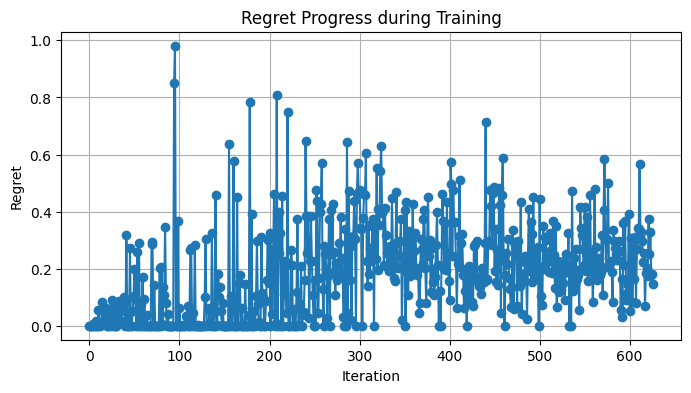


Done. Final buffer size: 0
Top-5 hardest levels (config, regret):
Top-5 easiest levels (config, regret):






Running PLR with config: {'name': 'plr_model_8x8', 'grid_size': 8, 'total_iterations': 512, 'train_steps': 1024, 'replay_prob': 0.7, 'level_buffer_size': 128, 'initial_fill_size': 64, 'regret_threshold': 0.0, 'n_envs': 2, 'edit_levels': False, 'easy_start': False, 'domain_randomization': False}
Initializing student model PPO...
Populating buffer with 64 initial levels with regret > 0.0...

Main training loop...

=== ITERATION 1/512 SKIPPED: 0 ===

=== ITERATION 6/512 SKIPPED: 0 ===

=== ITERATION 11/512 SKIPPED: 0 ===

=== ITERATION 16/513 SKIPPED: 1 ===

=== ITERATION 21/514 SKIPPED: 2 ===

=== ITERATION 26/516 SKIPPED: 4 ===
Regret for current level: 0.769199800491333, buffer size: 87

=== ITERATION 31/518 SKIPPED: 6 ===

=== ITERATION 36/518 SKIPPED: 6 ===

=== ITERATION 41/518 SKIPPED: 6 ===

=== ITERATION 46/520 SKIPPED: 8 ===

=== ITERATION 51/520 SKIPPED: 8 ===

=== ITERATION 56/520 SKIPPED: 8 ===
Regret for current level: 0.8136325597763061, buffer size: 114

=== ITERATION 

<Figure size 640x480 with 0 Axes>

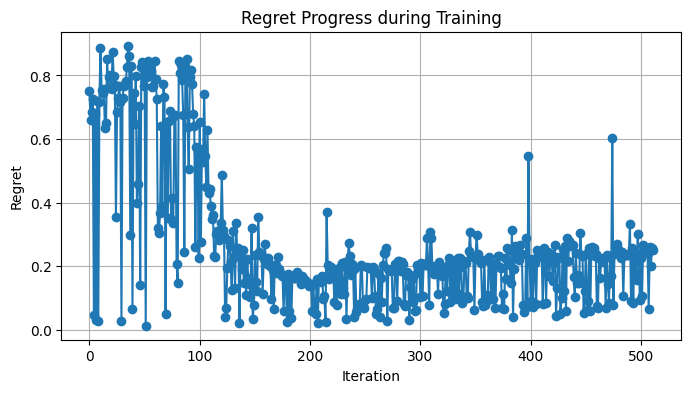


Done. Final buffer size: 128
Top-5 hardest levels (config, regret):
1. regret=0.89353, config={'width': 8, 'height': 8, 'num_blocks': 13, 'start_pos': (5, 1), 'goal_pos': (6, 1), 'edited': False, 'seed_val': 964703}
2. regret=0.88622, config={'width': 8, 'height': 8, 'num_blocks': 13, 'start_pos': (5, 1), 'goal_pos': (6, 1), 'edited': False, 'seed_val': 964703}
3. regret=0.87329, config={'width': 8, 'height': 8, 'num_blocks': 13, 'start_pos': (4, 6), 'goal_pos': (4, 5), 'edited': False, 'seed_val': 917345}
4. regret=0.86176, config={'width': 8, 'height': 8, 'num_blocks': 13, 'start_pos': (5, 1), 'goal_pos': (6, 1), 'edited': False, 'seed_val': 964703}
5. regret=0.85317, config={'width': 8, 'height': 8, 'num_blocks': 13, 'start_pos': (5, 1), 'goal_pos': (6, 1), 'edited': False, 'seed_val': 964703}
Top-5 easiest levels (config, regret):
1. regret=0.28344, config={'width': 8, 'height': 8, 'num_blocks': 3, 'start_pos': (4, 2), 'goal_pos': (2, 1), 'edited': False, 'seed_val': 168406}
2. re





Running ACCEL with config: {'name': 'accel_model_8x8', 'grid_size': 8, 'total_iterations': 512, 'train_steps': 1024, 'replay_prob': 0.7, 'level_buffer_size': 128, 'initial_fill_size': 64, 'regret_threshold': 0.0, 'n_envs': 2, 'edit_levels': True, 'easy_start': False, 'domain_randomization': False}
Initializing student model PPO...
Populating buffer with 64 initial levels with regret > 0.0...

Main training loop...

=== ITERATION 1/512 SKIPPED: 0 ===

=== ITERATION 6/512 SKIPPED: 0 ===

=== ITERATION 11/512 SKIPPED: 0 ===

=== ITERATION 16/514 SKIPPED: 2 ===

=== ITERATION 21/515 SKIPPED: 3 ===

=== ITERATION 26/516 SKIPPED: 4 ===
Regret for current level: 0.6931419388398529, buffer size: 89

=== ITERATION 31/516 SKIPPED: 4 ===

=== ITERATION 36/516 SKIPPED: 4 ===

=== ITERATION 41/516 SKIPPED: 4 ===

=== ITERATION 46/517 SKIPPED: 5 ===

=== ITERATION 51/518 SKIPPED: 6 ===

=== ITERATION 56/518 SKIPPED: 6 ===
Regret for current level: 0.8326346535913647, buffer size: 117

=== ITERAT

<Figure size 640x480 with 0 Axes>

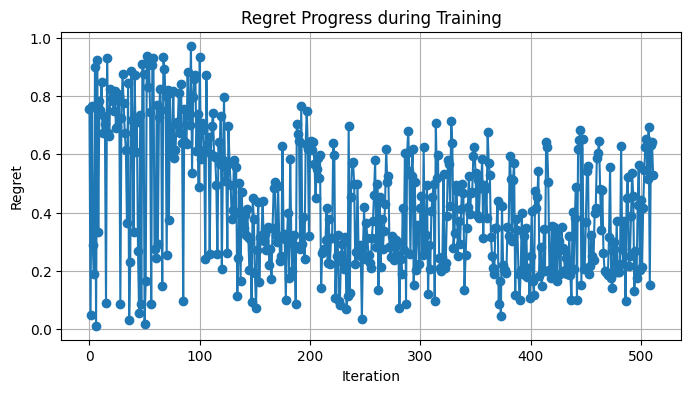


Done. Final buffer size: 128
Top-5 hardest levels (config, regret):
1. regret=0.97302, config={'width': 8, 'height': 8, 'num_blocks': 24, 'start_pos': (2, 4), 'goal_pos': (1, 4), 'edited': True, 'seed_val': 323744}
2. regret=0.93811, config={'width': 8, 'height': 8, 'num_blocks': 16, 'start_pos': (2, 4), 'goal_pos': (1, 4), 'edited': True, 'seed_val': 323744}
3. regret=0.93339, config={'width': 8, 'height': 8, 'num_blocks': 17, 'start_pos': (2, 4), 'goal_pos': (1, 4), 'edited': True, 'seed_val': 323744}
4. regret=0.93304, config={'width': 8, 'height': 8, 'num_blocks': 19, 'start_pos': (2, 4), 'goal_pos': (1, 4), 'edited': True, 'seed_val': 323744}
5. regret=0.93219, config={'width': 8, 'height': 8, 'num_blocks': 15, 'start_pos': (2, 4), 'goal_pos': (1, 4), 'edited': True, 'seed_val': 323744}
Top-5 easiest levels (config, regret):
1. regret=0.60382, config={'width': 8, 'height': 8, 'num_blocks': 13, 'start_pos': (6, 4), 'goal_pos': (4, 4), 'edited': True, 'seed_val': 645832}
2. regret=





Running ACCEL with easy start with config: {'name': 'accel_model_easy_8x8', 'grid_size': 8, 'total_iterations': 512, 'train_steps': 1024, 'replay_prob': 0.7, 'level_buffer_size': 128, 'initial_fill_size': 64, 'regret_threshold': 0.0, 'n_envs': 2, 'edit_levels': True, 'easy_start': True, 'domain_randomization': False}
Initializing student model PPO...
Populating buffer with 64 initial levels with regret > 0.0...

Main training loop...

=== ITERATION 1/512 SKIPPED: 0 ===

=== ITERATION 6/512 SKIPPED: 0 ===

=== ITERATION 11/514 SKIPPED: 2 ===

=== ITERATION 16/514 SKIPPED: 2 ===

=== ITERATION 21/514 SKIPPED: 2 ===

=== ITERATION 26/515 SKIPPED: 3 ===
Regret for current level: 0.17003452871561048, buffer size: 90

=== ITERATION 31/515 SKIPPED: 3 ===

=== ITERATION 36/515 SKIPPED: 3 ===

=== ITERATION 41/515 SKIPPED: 3 ===

=== ITERATION 46/515 SKIPPED: 3 ===

=== ITERATION 51/519 SKIPPED: 7 ===

=== ITERATION 56/519 SKIPPED: 7 ===
Regret for current level: 0.7841168203622103, buffer 

<Figure size 640x480 with 0 Axes>

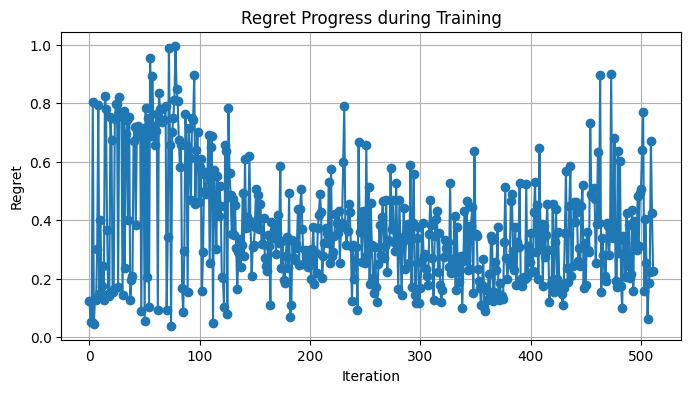


Done. Final buffer size: 128
Top-5 hardest levels (config, regret):
1. regret=0.99593, config={'width': 8, 'height': 8, 'num_blocks': 14, 'start_pos': (2, 4), 'goal_pos': (1, 4), 'edited': True, 'seed_val': 323744}
2. regret=0.98891, config={'width': 8, 'height': 8, 'num_blocks': 13, 'start_pos': (2, 4), 'goal_pos': (1, 4), 'edited': True, 'seed_val': 323744}
3. regret=0.95289, config={'width': 8, 'height': 8, 'num_blocks': 12, 'start_pos': (2, 4), 'goal_pos': (1, 4), 'edited': False, 'seed_val': 323744}
4. regret=0.89830, config={'width': 8, 'height': 8, 'num_blocks': 14, 'start_pos': (1, 4), 'goal_pos': (3, 5), 'edited': True, 'seed_val': 67008}
5. regret=0.89741, config={'width': 8, 'height': 8, 'num_blocks': 20, 'start_pos': (6, 1), 'goal_pos': (4, 3), 'edited': False, 'seed_val': 52670}
Top-5 easiest levels (config, regret):
1. regret=0.47089, config={'width': 8, 'height': 8, 'num_blocks': 13, 'start_pos': (4, 4), 'goal_pos': (2, 4), 'edited': True, 'seed_val': 343900}
2. regret=





Evaluating 10 levels of difficulty 1 with 8 blocks on a 8x8 grid for model DR, ratio of blocks to grid size: 0.12
Evaluating 10 levels of difficulty 2 with 16 blocks on a 8x8 grid for model DR, ratio of blocks to grid size: 0.25
Evaluating 10 levels of difficulty 3 with 24 blocks on a 8x8 grid for model DR, ratio of blocks to grid size: 0.38

Evaluating 10 levels of difficulty 1 with 8 blocks on a 8x8 grid for model PLR, ratio of blocks to grid size: 0.12
Evaluating 10 levels of difficulty 2 with 16 blocks on a 8x8 grid for model PLR, ratio of blocks to grid size: 0.25
Evaluating 10 levels of difficulty 3 with 24 blocks on a 8x8 grid for model PLR, ratio of blocks to grid size: 0.38

Evaluating 10 levels of difficulty 1 with 8 blocks on a 8x8 grid for model ACCEL, ratio of blocks to grid size: 0.12
Evaluating 10 levels of difficulty 2 with 16 blocks on a 8x8 grid for model ACCEL, ratio of blocks to grid size: 0.25
Evaluating 10 levels of difficulty 3 with 24 blocks on a 8x8 grid fo

<Figure size 640x480 with 0 Axes>

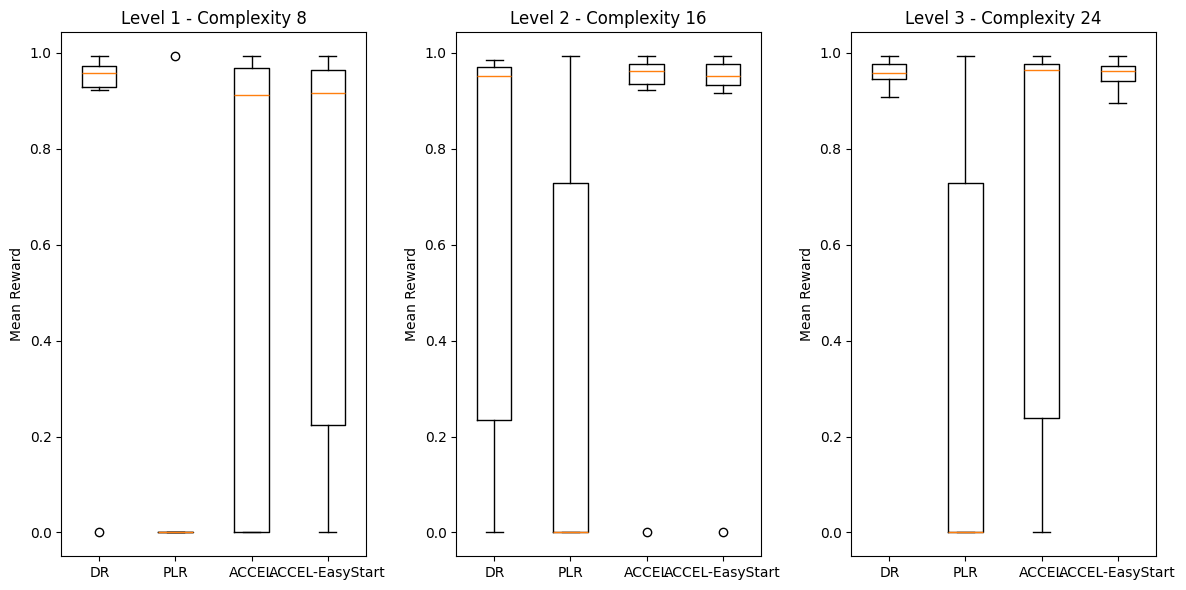

<Figure size 640x480 with 0 Axes>

In [27]:
import time

if __name__ == "__main__":
        
    wandb.finish()
        
    config = {
            "name": "model",
            "grid_size": 8,
            
            "total_iterations": 512,
            "train_steps": 1024,

            "replay_prob": 0.7,            # Probability of replaying a level and editing it vs. generating a new one
            "level_buffer_size": 128,       # Maximum number of levels to store in the buffer
            "initial_fill_size": 64,       # Number of levels to pre-fill the buffer with
            "regret_threshold": 0.00,      # Minimum regret threshold to consider a level for the buffer
            
            "n_envs": 2,                   # Number of parallel environments to use for training
            
            "edit_levels": True,           # Whether to edit levels during training i.e. ACCEL or PLR
            "easy_start": True,            # Whether to fill the buffer with easy levels first i.e. minimum number of blocks
            "domain_randomization": False, # Whether to use domain randomization
    
        }


    config["name"] = f"dr_model_{config['grid_size']}x{config['grid_size']}"
    config["domain_randomization"] = True
    config["edit_levels"] = False
    config["easy_start"] = False
    print(f"Running Domain Randomization with config: {config}")
    model_dr = main_accel(**config)
        
    print("\n\n============================================\n\n")
    
    config["name"] = f"plr_model_{config['grid_size']}x{config['grid_size']}"
    config["domain_randomization"] = False
    config["edit_levels"] = False
    config["easy_start"] = False
    print(f"Running PLR with config: {config}")
    model_plr = main_accel(**config)

    print("\n\n============================================\n\n")


    config["name"] = f"accel_model_{config['grid_size']}x{config['grid_size']}"
    config["domain_randomization"] = False
    config["edit_levels"] = True
    config["easy_start"] = False
    print(f"Running ACCEL with config: {config}")
    model_accel = main_accel(**config)

    print("\n\n============================================\n\n")
    
    config["name"] = f"accel_model_easy_{config['grid_size']}x{config['grid_size']}"
    config["domain_randomization"] = False
    config["edit_levels"] = True
    config["easy_start"] = True
    print(f"Running ACCEL with easy start with config: {config}")
    model_accel_easy = main_accel(**config)
    
    print("\n\n============================================\n\n")

    # Evaluate the models
    evalute_models(load_dim = config["grid_size"], grid_size = config["grid_size"], n_eval_episodes = 5, num_levels_per_difficulty = 10)

## TESTS

Evaluating 30 levels of difficulty 1 with 12 blocks on a 12x12 grid for model DR, ratio of blocks to grid size: 0.08
Evaluating 30 levels of difficulty 2 with 24 blocks on a 12x12 grid for model DR, ratio of blocks to grid size: 0.17
Evaluating 30 levels of difficulty 3 with 36 blocks on a 12x12 grid for model DR, ratio of blocks to grid size: 0.25

Evaluating 30 levels of difficulty 1 with 12 blocks on a 12x12 grid for model PLR, ratio of blocks to grid size: 0.08
Evaluating 30 levels of difficulty 2 with 24 blocks on a 12x12 grid for model PLR, ratio of blocks to grid size: 0.17
Evaluating 30 levels of difficulty 3 with 36 blocks on a 12x12 grid for model PLR, ratio of blocks to grid size: 0.25

Evaluating 30 levels of difficulty 1 with 12 blocks on a 12x12 grid for model ACCEL, ratio of blocks to grid size: 0.08
Evaluating 30 levels of difficulty 2 with 24 blocks on a 12x12 grid for model ACCEL, ratio of blocks to grid size: 0.17
Evaluating 30 levels of difficulty 3 with 36 blocks o

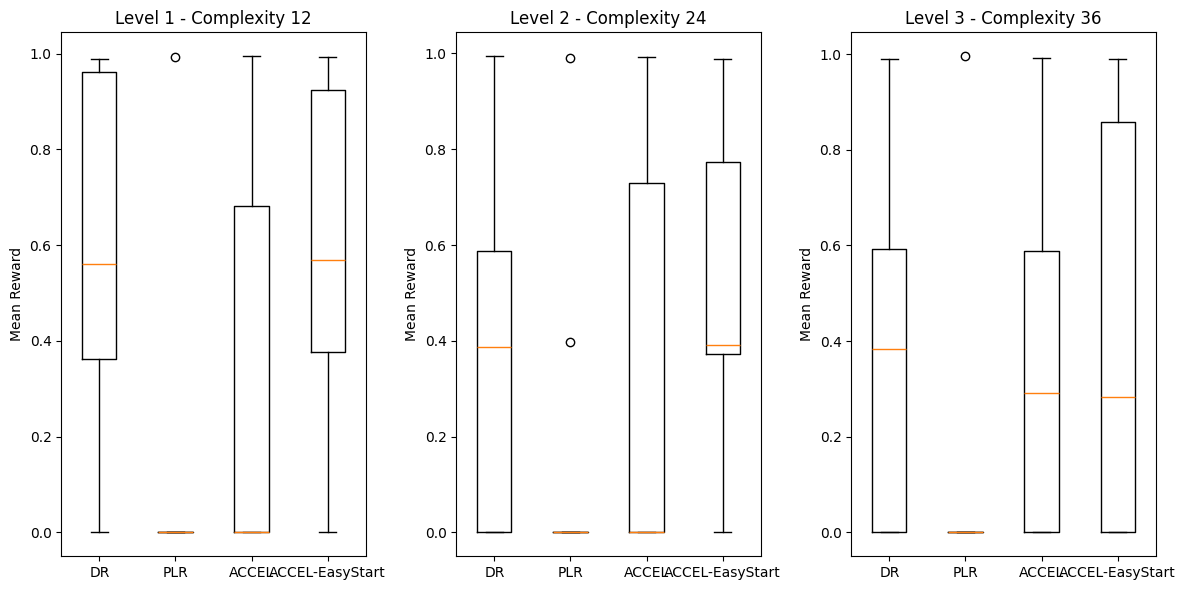

Testing model DR on previously evaluated levels...


NameError: name 'levels' is not defined

<Figure size 640x480 with 0 Axes>

In [7]:
evalute_models(load_dim=8, grid_size=12, n_eval_episodes=10, num_levels_per_difficulty=30)


def test_model(model, config, gif_path="level.gif"):
    env = MyCustomGrid(config, render_mode='rgb_array', solvable_only=True)
    obs, _ = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    i = 0

    frames = []  # List to store frames

    # Continue until either terminated or truncated is True
    while not (terminated or truncated):
        frame = env.render()  # Capture frame as an image
        frames.append(Image.fromarray(frame))  # Convert to PIL image and store
        
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        i += 1
        if i > 20:
            break
    
    # Add to the gif also the last frame
    frame = env.render()
    frames.append(Image.fromarray(frame))

    # Save frames as a GIF
    if frames:
        frames[0].save(
            gif_path, save_all=True, append_images=frames[1:], duration=500, loop=0
        )

    env.close()
    return total_reward


def load_models(grid_size):
    # Load the models
    model_dr = PPO.load(f"models/dr_model_{grid_size}x{grid_size}")
    model_plr = PPO.load(f"models/plr_model_{grid_size}x{grid_size}")
    model_accel = PPO.load(f"models/accel_model_{grid_size}x{grid_size}")
    model_accel_easy = PPO.load(f"models/accel_model_easy_{grid_size}x{grid_size}")
    
    return model_dr, model_plr, model_accel, model_accel_easy

model_dr, model_plr, model_accel, model_accel_easy = load_models(8)
# Test the models on a few ranom levels
for i in range(10):
    reward = test_model(model_dr, random_config(8), gif_path=f"gifs/level_{i}_dr.gif")
    print(f"Reward for level {i} with DR: {reward:.2f}")
    reward =test_model(model_plr, random_config(8), gif_path=f"gifs/level_{i}_plr.gif")
    print(f"Reward for level {i} with PLR: {reward:.2f}")
    reward =test_model(model_accel, random_config(8), gif_path=f"gifs/level_{i}_accel.gif")
    print(f"Reward for level {i} with ACCEL: {reward:.2f}")
    reward =test_model(model_accel_easy, random_config(8), gif_path=f"gifs/level_{i}_accel_easy.gif")
    print(f"Reward for level {i} with ACCEL-EasyStart: {reward:.2f}")

"""
models = {
    "DR": model_dr,
    "PLR": model_plr,
    "ACCEL": model_accel,
    "ACCEL-EasyStart": model_accel_easy
}
    
# Test the models on previously evaluated levels
for model_name, model in models.items():
    print(f"Testing model {model_name} on previously evaluated levels...")
    for i, level in enumerate(levels):
        print(f"Level {i + 1} - Complexity {(i+2)**2}:")
        for j, cfg in enumerate(level):
            mean_reward = test_model(model, cfg)
            print(f"  Config {j + 1}: {mean_reward:.2f}")
        print()
    print()

In [ ]:
# Train a easy_start model just on edited levels to create a gif of increasing level complexity



# Generate a random level and visualize it
random_cnf = random_config(8)
print("random_cnf:", random_cnf)

print_level_from_config(random_cnf, solvable_only=True)

# test the model on the random level
test_model(model_accel_easy, random_cnf)

In [3]:
import random
from PIL import Image

def test_model(model, env, gif_path="level.gif"):
    """Evaluate a model on a given environment instance."""
    obs, _ = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    i = 0

    frames = []  # List to store frames

    # Continue until either terminated or truncated is True
    while not (terminated or truncated):
        frame = env.render()  # Capture frame as an image
        frames.append(Image.fromarray(frame))  # Convert to PIL image and store
        
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        i += 1
        if i > 20:
            break
    
    # Add to the gif also the last frame
    frame = env.render()
    frames.append(Image.fromarray(frame))

    # Save frames as a GIF
    if frames:
        frames[0].save(
            gif_path, save_all=True, append_images=frames[1:], duration=500, loop=0
        )

    return total_reward  # Do not close env here, as we reuse it


def load_models(grid_size):
    """Load the RL models."""
    model_dr = PPO.load(f"models/dr_model_{grid_size}x{grid_size}")
    model_plr = PPO.load(f"models/plr_model_{grid_size}x{grid_size}")
    model_accel = PPO.load(f"models/accel_model_{grid_size}x{grid_size}")
    model_accel_easy = PPO.load(f"models/accel_model_easy_{grid_size}x{grid_size}")
    
    return model_dr, model_plr, model_accel, model_accel_easy


model_dr, model_plr, model_accel, model_accel_easy = load_models(8)

# Test the models on the same exact environment instance
for i in range(10):
    config = random_config(8, seed=i)
    env = MyCustomGrid(config, render_mode='rgb_array', solvable_only=True)  # Create one environment per level
    # Inizialize the environment for each model
    env.reset()

    reward = test_model(model_dr, env, gif_path=f"gifs/level_{i}_dr.gif")
    print(f"Reward for level {i} with DR: {reward:.2f}")
    
    reward = test_model(model_plr, env, gif_path=f"gifs/level_{i}_plr.gif")
    print(f"Reward for level {i} with PLR: {reward:.2f}")
    
    reward = test_model(model_accel, env, gif_path=f"gifs/level_{i}_accel.gif")
    print(f"Reward for level {i} with ACCEL: {reward:.2f}")
    
    reward = test_model(model_accel_easy, env, gif_path=f"gifs/level_{i}_accel_easy.gif")
    print(f"Reward for level {i} with ACCEL-EasyStart: {reward:.2f}")

    env.close()  # Close environment after all models have been tested on it


Reward for level 0 with DR: 0.95
Reward for level 0 with PLR: 0.00
Reward for level 0 with ACCEL: 0.00
Reward for level 0 with ACCEL-EasyStart: 0.92
Reward for level 1 with DR: 0.95
Reward for level 1 with PLR: 0.00
Reward for level 1 with ACCEL: 0.94
Reward for level 1 with ACCEL-EasyStart: 0.96
Reward for level 2 with DR: 0.00
Reward for level 2 with PLR: 0.00
Reward for level 2 with ACCEL: 0.96
Reward for level 2 with ACCEL-EasyStart: 0.91
Reward for level 3 with DR: 0.95
Reward for level 3 with PLR: 0.00
Reward for level 3 with ACCEL: 0.00
Reward for level 3 with ACCEL-EasyStart: 0.89
Reward for level 4 with DR: 0.96
Reward for level 4 with PLR: 0.00
Reward for level 4 with ACCEL: 0.94
Reward for level 4 with ACCEL-EasyStart: 0.97
Reward for level 5 with DR: 0.97
Reward for level 5 with PLR: 0.00
Reward for level 5 with ACCEL: 0.00
Reward for level 5 with ACCEL-EasyStart: 0.90
Reward for level 6 with DR: 0.96
Reward for level 6 with PLR: 0.00
Reward for level 6 with ACCEL: 0.96
Rew

# Bipedal Walker

In [ ]:
# Reference: https://gymnasium.farama.org/environments/box2d/bipedal_walker/

import gymnasium as gym
import numpy as np
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.utils import obs_as_tensor
import random

device = 'cpu'

class BipedalWalkerParamWrapper(gym.Wrapper):
    """
    A wrapper around BipedalWalker (or BipedalWalkerHardcore) 
    that sets custom parameters for terrain generation at reset time.
    """

    def __init__(self, env_id="BipedalWalker-v3", hardcore=False):
        super().__init__(gym.make(env_id))
        self.hardcore = hardcore

        # The environment's internal parameters. 
        # We will override these at reset to control terrain generation.
        self.config = {
            "seed_val": None,
            "stump_height": 0.0,
            "stair_height": 0.0,
            "stair_steps": 1,
            "roughness": 0.0,
            "pit_gap": 0.0,
        }

        # If we want hardcore version, you can do so with:
        if self.hardcore:
            self.env = gym.make("BipedalWalkerHardcore-v3")

    def set_config(self, config_dict):
        """Update environment parameters."""
        for k, v in config_dict.items():
            self.config[k] = v

    def reset(self, **kwargs):
        """
        Modify the environment's terrain parameters right before reset.
        This monkey-patches internal Box2D variables, if needed,
        or sets seeds to randomize terrain accordingly.
        """
        # 1) Seed:
        #if self.config["seed_val"] is not None:
        #    self.env.seed(self.config["seed_val"])

        # 2) Override terrain parameters in the underlying env
        #    (We rely on the environment reading these at reset or having
        #     references in the terrain generation code. Depending on 
        #     your exact BipedalWalker implementation, you might need 
        #     to modify the source or do partial overrides.)
        self.env.unwrapped.stump_height = self.config["stump_height"]
        self.env.unwrapped.stair_height = self.config["stair_height"]
        self.env.unwrapped.stair_steps = int(self.config["stair_steps"])
        self.env.unwrapped.roughness = self.config["roughness"]
        self.env.unwrapped.pit_gap = self.config["pit_gap"]

        obs = self.env.reset(**kwargs)
        return obs

    def step(self, action):
        return self.env.step(action)
    


# The min and max values for each terrain parameter.
# For simplicity, define them here, but you can store these in a table/dict.
PARAM_BOUNDS = {
    "stump_height":  (0.0, 5.0),
    "stair_height":  (0.0, 5.0),
    "stair_steps":   (1,   9),
    "roughness":     (0.0, 10.0),
    "pit_gap":       (0.0, 10.0)
}

def random_config(easy_init=False):
    """
    Sample a random environment config. If easy_init=True,
    you might restrict sampling to small values, so the agent
    starts with simpler terrain.
    """
    cfg = {}
    
    # Optionally set a random seed 
    cfg["seed_val"] = random.randint(0, 1_000_000)

    def sample_uniform(low, high):
        return random.uniform(low, high)

    if easy_init:
        # Possibly narrower range for simpler (initial) levels
        cfg["stump_height"] = sample_uniform(0.0, 0.4)
        cfg["stair_height"] = sample_uniform(0.0, 0.4)
        cfg["stair_steps"]  = random.randint(1, 2)
        cfg["roughness"]    = sample_uniform(0.0, 0.6)
        cfg["pit_gap"]      = sample_uniform(0.0, 0.8)
    else:
        cfg["stump_height"] = sample_uniform(*PARAM_BOUNDS["stump_height"])
        cfg["stair_height"] = sample_uniform(*PARAM_BOUNDS["stair_height"])
        cfg["stair_steps"]  = random.randint(*PARAM_BOUNDS["stair_steps"])
        cfg["roughness"]    = sample_uniform(*PARAM_BOUNDS["roughness"])
        cfg["pit_gap"]      = sample_uniform(*PARAM_BOUNDS["pit_gap"])

    return cfg

def edit_config(old_cfg):
    """
    Make a small 'mutation' to the old_cfg.
    This can be random increments/decrements to each parameter, 
    or randomly choose one parameter to mutate.
    """
    new_cfg = dict(old_cfg)
    param_to_edit = random.choice(["stump_height", "stair_height", "stair_steps", "roughness", "pit_gap"])
    # pick small delta 
    delta = random.uniform(0.1, 1.0)

    # Add or subtract
    sign = random.choice([-1, 1])
    new_val = new_cfg[param_to_edit] + sign * delta
    
    # Clip to valid range
    low, high = PARAM_BOUNDS[param_to_edit]
    new_cfg[param_to_edit] = np.clip(new_val, low, high)

    # Possibly update the seed too 
    new_cfg["seed_val"] = random.randint(0, 1_000_000)
    return new_cfg



class LevelReplayBuffer:
    """
    Stores (config, score). Score is e.g. a 'regret' approximation.
    We keep the highest-score configs up to max_size.
    """
    def __init__(self, max_size=100):
        self.max_size = max_size
        self.data = []

    def add(self, cfg, score):
        self.data.append((cfg, score))
        # keep only top K by score
        self.data.sort(key=lambda x: x[1], reverse=True)
        self.data = self.data[:self.max_size]

    def sample(self):
        if len(self.data) == 0:
            return None
        # Weighted sample by score or just pick the top 
        # For simplicity, pick randomly from top half:
        half = len(self.data) // 2
        idx = np.random.randint(0, max(1, half))
        return self.data[idx][0]

def estimate_regret(env, model, max_steps=1000, gamma=0.99, lam=0.95):
    """
    Calculate regret using Generalized Advantage Estimation (GAE)
    with Stable-Baselines3's PPO model.
    """
    obs = env.reset()[0]
    regrets = []
    rewards = []
    dones = []
    values = []
    

    for t in range(max_steps):
        # Add batch dimension to the observation tensor
        obs_tensor = torch.as_tensor(obs).float().unsqueeze(0).to(device)
        
        # Use the model's policy to get the value and action.
        # For actions, model.predict handles single observations well.
        action, _ = model.predict(obs, deterministic=True)
        
        # Compute the value from the policy.
        value_t = model.policy.predict_values(obs_tensor).item()
        values.append(value_t)
        
        # Perform the step in the environment
        obs, reward, done, truncated, _ = env.step(action)
        rewards.append(reward)
        dones.append(done)

        if done or truncated:
            break

    # Add value of the terminal state (0 if done/truncated)
    if done or truncated:
        terminal_value = 0.0
    else:
        terminal_obs_tensor = torch.as_tensor(obs).float().unsqueeze(0).to(device)
        terminal_value = model.policy.predict_values(terminal_obs_tensor).item()
    values.append(terminal_value)

    # Compute TD-errors and GAE-like regret score
    for t in range(len(rewards)):
        delta_t = rewards[t] + gamma * values[t + 1] * (1 - dones[t]) - values[t]
        discounted_error = (gamma * lam) ** t * delta_t
        regrets.append(max(0, discounted_error))

    # Return the maximum positive regret score (or 0 if empty)
    return max(regrets) if regrets else 0.0

def run_accel_bipedal(
    total_iterations=50,
    steps_per_iteration=10000,
    replay_prob=0.8,
    regret_threshold=1.0,
    max_buf_size=100,
    easy_start=True
):
    """
    Minimal ACCEL training loop on BipedalWalker.
    """
    # 1) Create the environment wrapper + vectorize
    def make_env():
        env = BipedalWalkerParamWrapper(env_id="BipedalWalkerHardcore-v3", hardcore=True)
        return env
    
    # (Alternatively, do SubprocVecEnv if you want parallel CPU rollouts.)
    vec_env = DummyVecEnv([make_env])

    # 2) Initialize PPO
    model = PPO(
        "MlpPolicy", 
        vec_env, 
        n_steps=2048,        # must be multiple of vec_env.num_envs
        batch_size=64,
        learning_rate=3e-4,
        gamma=0.99,
        verbose=0,
    )

    # 3) Create LevelReplayBuffer
    level_buffer = LevelReplayBuffer(max_size=max_buf_size)

    # 4) [Optional] Pre-fill buffer with some easy or random levels
    for _ in range(10):  # pre-fill 10 levels
        print("Pre-filling buffer...")
        cfg = random_config(easy_init=easy_start)
        env = make_env()  # fresh environment
        env.set_config(cfg)
        # Train on it briefly to get a partial updated policy 
        model.set_env(DummyVecEnv([lambda: env]))
        model.learn(total_timesteps=2000)

        # Evaluate regret
        rew_env = make_env()
        rew_env.set_config(cfg)
        regret = estimate_regret(rew_env, model)

        if regret >= regret_threshold:
            level_buffer.add(cfg, regret)
        
    
    print("Buffer pre-filled. Starting main loop...")

    # 5) ACCEL main loop
    for it in range(total_iterations):
        # Decide: replay from buffer or create new
        use_replay = (np.random.rand() < replay_prob) and (len(level_buffer.data) > 0)
        if use_replay:
            cfg = level_buffer.sample()
            # Optionally edit the config to keep pushing frontier
            cfg = edit_config(cfg)
        else:
            cfg = random_config(easy_init=False)

        # Train on that config
        env = make_env()
        env.set_config(cfg)
        model.set_env(DummyVecEnv([lambda: env]))
        model.learn(total_timesteps=steps_per_iteration)

        # Now measure regret
        rew_env = make_env()
        rew_env.set_config(cfg)
        regret = estimate_regret(rew_env, model)

        if regret >= regret_threshold:
            level_buffer.add(cfg, regret)

        print(f"[Iteration {it+1}/{total_iterations}] => Config = {cfg}, Regret = {regret:.3f}, "
              f"Buffer size = {len(level_buffer.data)}")

    return model, level_buffer



if __name__ == "__main__":
    trained_model, buffer_data = run_accel_bipedal(
        total_iterations=250,
        steps_per_iteration=1000,
        replay_prob=0.8,
        regret_threshold=1.0,
        max_buf_size=100,
        easy_start=True
    )


In [ ]:

    # Evaluate final performance on some reference environment
    test_env = gym.make("BipedalWalkerHardcore-v3", render_mode='human')
    mean_return = 0.0
    N = 10
    for _ in range(N):
        obs = test_env.reset()[0]
        done = False
        episode_reward = 0.0
        while not done:
            action, _ = trained_model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = test_env.step(action)
            episode_reward += reward
            if truncated:
                done = True
        mean_return += episode_reward
    mean_return /= N
    print(f"Avg Return on BipedalWalkerHardcore-v3 over {N} trials: {mean_return}")



# Maze generator

In [ ]:
class MyCustomMaze(MiniGridEnv):
    """
    Simple MiniGrid environment that places random wall tiles
    according to a config dict, returning only the 'image' observation.
    """

    def __init__(self, config=None, **kwargs):
        if config is None:
            config = {}
        self.config = config

        # Extract parameters from config
        self.width = config.get("width")
        self.height = config.get("height")
        self.num_blocks = config.get("num_blocks")
        self.custom_seed = config.get("seed_val")
        
        
        # Create a random number generator with the custom seed
        self.rng = np.random.default_rng(seed=self.custom_seed)

        grid_size = max(self.width, self.height)

        mission_space = MissionSpace(mission_func=lambda: "get to the green goal square")

        super().__init__(
            grid_size=grid_size,
            max_steps=self.width * self.height * 2, # max_steps is typically 2x the grid size
            see_through_walls=False,
            agent_view_size=5,                      # Size of the agent's view square
            mission_space=mission_space,
            **kwargs
        )

        # Manually define our observation_space as a single Box (the image).
        # By default, MiniGrid's image shape is (view_size, view_size, 3) if using partial obs,
        # or (height, width, 3) if using full-grid observation. We'll do full-grid here:
        # We'll define (self.height, self.width, 3) as the shape.
        # In practice, "image" shape can vary if partial observations are used.
        self.observation_space = Box(
            low=0,
            high=255,
            shape=(self.agent_view_size, self.agent_view_size, 3),
            dtype=np.uint8
        )

    
    def _gen_grid(self, width, height):
        """
        Generate the grid layout for a new episode using the DFS Maze Generation Algorithm.
        """
        # Create an empty grid of the "true" width x height from config
        self.grid = Grid(self.width, self.height)
        # Surround the grid with walls
        self.grid.wall_rect(0, 0, self.width, self.height)

        # Initialize the maze as walls
        maze = [[1 for _ in range(self.width)] for _ in range(self.height)]

        # Define directions for DFS
        directions = [(0, 2), (0, -2), (2, 0), (-2, 0)]

        def is_valid(x, y):
            """Check if a cell is valid for carving."""
            return 0 < x < self.height - 1 and 0 < y < self.width - 1 and maze[x][y] == 1

        def carve(x, y):
            """Carve passages in the maze using DFS."""
            maze[x][y] = 0  # Mark the cell as part of the maze
            self.grid.set(x, y, None)  # Clear the wall in the grid
            self.rng.shuffle(directions)
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                if is_valid(nx, ny):
                    # Remove the wall between cells
                    maze[x + dx // 2][y + dy // 2] = 0
                    self.grid.set(x + dx // 2, y + dy // 2, None)
                    carve(nx, ny)

        # Start carving from the top-left corner
        carve(1, 1)

        # Place the goal object in a random position not occupied by a wall
        while True:
            r = self.rng.integers(1, self.height - 1)
            c = self.rng.integers(1, self.width - 1)
            if self.grid.get(c, r) is None:
                self.put_obj(Goal(), c, r)
                break

        # Place the agent in a random position not occupied by a wall and not on the goal
        while True:
            r = self.rng.integers(1, self.height - 1)
            c = self.rng.integers(1, self.width - 1)
            if self.grid.get(c, r) is None:
                self.place_agent(top=(c, r), rand_dir=True)
                break
    
    
    def reset(self, **kwargs):
        """
        Override reset to ensure we only return the 'image' array
        instead of a dict with 'image' and 'mission'.
        """
        obs, info = super().reset(**kwargs)
        obs = self._convert_obs(obs)
        return obs, info

    def step(self, action):
        """
        Same for step: override to convert the dict observation into an image only.
        """
        obs, reward, done, truncated, info = super().step(action)
        obs = self._convert_obs(obs)
        return obs, reward, done, truncated, info

    def _convert_obs(self, original_obs):
        """
        original_obs is typically {'image':..., 'mission':...}.
        We'll just return original_obs['image'] to get a Box(low=0,high=255) shape.
        """
        return original_obs["image"]
        #return np.transpose(original_obs["image"], (2, 0, 1))



def print_maze_from_config(config):
    env = MyCustomMaze(config, render_mode='rgb_array')
    env.reset()
    full_level_image = env.render()  # This should return an RGB image of the full grid

    plt.figure(figsize=(4, 4))
    plt.imshow(full_level_image)
    plt.title("Maze Configuration: " + str(config))
    plt.axis("off")
    plt.show()
    

# Generate a random maze and visualize it
random_maze = random_config(6)
print_maze_from_config(random_maze)



# OLD CODE, NOT VECORIZED, REDUNDANT CODE

"""
# ====================================================
# 4. Main ACCEL Loop
# ====================================================

def main_accel_demo(total_iterations, replay_prob, train_steps, level_buffer_size,
                    initial_fill_size, grid_size):
    
    
    # Create a level buffer to store generated levels and their scores
    level_buffer = LevelBuffer(max_size=level_buffer_size)
    iteration_regrets = []
        
    #Create a dummy environment to initialize the model
    dummy_env = MyCustomGrid(random_config(grid_size))
    vectorized_env = create_vectorized_env(dummy_env, n_envs=4)

    # Initialize student model with PPO
    print("Initializing student model PPO...")
    student_model = initialize_ppo(dummy_env)

    skipped = 0

    # Populate buffer with initial levels
    print(f"Populating buffer with {initial_fill_size} initial levels with regret != 0...")
    for _ in range(initial_fill_size + skipped):
        cfg = random_config(grid_size)
        regret = calculate_regret_gae(MyCustomGrid(cfg), student_model, max_steps=1000, gamma=0.99, lam=0.95)
        
        # Skip levels with 0 regret
        if regret == 0:
            skipped += 1
            continue
        
        level_buffer.add(cfg, regret)
        
    
    print("\nDone. Number of skipped levels with zero regret:", skipped)
    
    skipped = 0
    iteration = 0
    # Main ACCEL loop
    print("\nMain ACCEL loop...")
    while iteration < total_iterations + skipped:
        print(f"\n=== ITERATION {iteration + 1}/{total_iterations} SKIPPED {skipped} ===")
        
        iteration += 1
        
        # Decide whether to use replay or generate a new level
        use_replay = np.random.rand() < replay_prob
        
        # Generates new random levels if you don't use replay
        if not use_replay or len(level_buffer.data) == 0:
            cfg = random_config(grid_size)
            regret = calculate_regret_gae(MyCustomGrid(cfg), student_model, max_steps=100, gamma=0.99, lam=0.95)
            
            if regret == 0:
                skipped += 1
                continue
            
            level_buffer.add(cfg, regret)
            print(f"  Sampled new config, regret={regret:.3f}")
        else:
            # Replays an existing layer, edits it, and evaluates the new layer
            old_cfg = level_buffer.sample_config()
            env = MyCustomGrid(old_cfg)
            
            student_model.set_env(env)
            student_model.learn(total_timesteps=train_steps)

            new_cfg = edit_config(old_cfg)
            regret = calculate_regret_gae(MyCustomGrid(new_cfg), student_model, max_steps=100, gamma=0.99, lam=0.95)
            
            if regret == 0:
                skipped += 1
                continue
            
            level_buffer.add(new_cfg, regret)
            print(f"  Replayed + mutated config, regret={regret:.3f}")
        
        iteration_regrets.append(regret)
    
    print("\nDone. Number of skipped levels with zero regret:", skipped)

    # Visualize progress of the regret over iterations.
    plt.figure(figsize=(8, 4))
    plt.plot(iteration_regrets, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Regret")
    plt.title("Regret Progress during ACCEL Training")
    plt.grid(True)
    plt.show()
    
    
    

if __name__ == "__main__":
    
    
    config = {
        "grid_size": 8,
        
        "total_iterations": 64,
        "train_steps": 1024,

        "replay_prob": 0.7,           # Probability of replaying a level and editing it vs. generating a new one
        "level_buffer_size": 128,     # Maximum number of levels to store in the buffer
        "initial_fill_size": 64,      # Number of levels to pre-fill the buffer with
        "regret_threshold": 0.0,      # Minimum regret threshold to consider a level for the buffer
        
        "n_envs": 8,                  # Number of parallel environments to use for training
        
        "edit_levels": True,          # Whether to edit levels during training i.e. ACCEL or PLR
        "easy_start": True            # Whether to fill the buffer with easy levels first i.e. minimum number of blocks
    }
    
    print("Running ACCEL with config:")
    print(config, "\n")
    
    main_accel(**config)




def calculate_regret_gae_parallel(env_config, model, max_steps=1000, gamma=0.99, lam=0.95, n_envs=4):
    '''
    Roll out n_envs copies of MyCustomGrid(env_config) in parallel,
    compute GAE-based 'regret' for each environment, and return the max.
    '''

    # Create vectorized env with n_envs copies
    vec_env = create_vectorized_env(env_config, n_envs=n_envs)
    obs_array = vec_env.reset()  # shape: (n_envs, height, width, 3)

    # For each environment, we will store transitions to later compute GAE
    # We'll keep them in lists, one per environment.
    # Alternatively, we can store them in big arrays (n_envs, max_steps), etc.
    rewards_list = [[] for _ in range(n_envs)]
    values_list = [[] for _ in range(n_envs)]
    dones_list = [[] for _ in range(n_envs)]

    for t in range(max_steps):
        # Model’s predict can handle multiple obs in a single forward pass
        actions, _ = model.predict(obs_array, deterministic=True)
        
        # Also compute the values in one batch
        # Convert obs_array to torch tensor
        obs_tensor = torch.as_tensor(np.transpose(obs_array, (0, 3, 1, 2))).float().to(device)
        with torch.no_grad():
            # shape: (n_envs, 1)
            value_t = model.policy.predict_values(obs_tensor).cpu().numpy().flatten()

        # Step all envs in parallel
        next_obs_array, rewards, dones, truncs = vec_env.step(actions)

        # Store the results
        for i in range(n_envs):
            rewards_list[i].append(rewards[i])
            values_list[i].append(value_t[i])
            dones_list[i].append(bool(dones[i]) or bool(truncs[i]))

        obs_array = next_obs_array

        # If all envs are done or truncated, we can break early
        if all(dones) or all(truncs):
            break

    # We also need the terminal value for each env
    # (0 if done, otherwise model's value at final obs)
    obs_tensor = torch.as_tensor(np.transpose(obs_array, (0, 3, 1, 2))).float().to(device)
    with torch.no_grad():
        final_values = model.policy.predict_values(obs_tensor).cpu().numpy().flatten()

    # Now, compute GAE-based "regret" for each of the n_envs
    regrets = []
    for i in range(n_envs):
        # If the env ended with done or truncated, terminal value = 0
        if dones_list[i][-1]:
            values_list[i].append(0.0)
        else:
            values_list[i].append(final_values[i])

        # Compute delta_t and approximate GAE-like metric
        env_rewards = rewards_list[i]
        env_values = values_list[i]
        env_dones = dones_list[i]

        env_regrets = []
        for t in range(len(env_rewards)):
            delta_t = env_rewards[t] + gamma * env_values[t + 1] * (1 - env_dones[t]) - env_values[t]
            # accumulate discounted error
            discounted_error = (gamma * lam) ** t * delta_t
            env_regrets.append(max(0, discounted_error))

        # The environment's "regret" is the max of its positive GAE deltas
        regrets.append(max(env_regrets) if env_regrets else 0.0)

    # Return the maximum regret across the parallel envs
    return max(regrets) if regrets else 0.0




"""
    def _gen_grid(self, width, height):
        '''
        Generate the grid layout for a new episode.
        We use self.width and self.height from config, even though the underlying
        MiniGrid environment might use grid_size for some of its operations.
        '''    
        
        # Create an empty grid of the "true" width x height from config
        self.grid = Grid(self.width, self.height)
        # Surround the grid with walls
        self.grid.wall_rect(0, 0, self.width, self.height)
        
        # Place random walls inside using the custom seed. Only place a wall if the cell is empty.
        for _ in range(self.num_blocks):
            r = self.rng.integers(1, self.height - 1)
            c = self.rng.integers(1, self.width - 1)
            if self.grid.get(c, r) is None: #and (c, r) != self.config["start_pos"] and (c, r) != self.config["goal_pos"]:
                self.put_obj(Wall(), c, r)
        
        # Place the goal object in a random position not occupied by any wall
        """if self.config["goal_pos"] is None:"""
        while True:
            r = self.rng.integers(1, self.height - 1)
            c = self.rng.integers(1, self.width - 1)
            if self.grid.get(c, r) is None: # and (c, r) != self.config["start_pos"]:
                self.put_obj(Goal(), c, r)
                self.config["goal_pos"] = (c, r)
                break
        """elif self.config["goal_pos"] is not None:
            c, r = self.config["goal_pos"]
            self.put_obj(Goal(), c, r)"""

        # Place the agent in a random position not occupied by any wall and not on the goal
        
        """if self.config["start_pos"] is None:"""
        while True:
            r = self.rng.integers(1, self.height - 1)
            c = self.rng.integers(1, self.width - 1)
            if self.grid.get(c, r) is None: # and (c, r) != self.config["goal_pos"]:
                self.place_agent(top=(c, r), rand_dir=True)
                self.config["start_pos"] = (c, r)
                break  
        """elif self.config["start_pos"] is not None:
            c, r = self.config["start_pos"]
            self.place_agent(top=(c, r), rand_dir=True)"""'''
            

"""